In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim
from celluloid import Camera
import scipy as sp
from scipy import integrate
from matplotlib import rc 
import os.path as path
import wget
import pandas as pd

# Colisiones 2D de duración finita

In [2]:
#Clase partícula

class Particle():
    
    def __init__(self, x0, v0, a0, t, m, radio, Id, f0):   
                                                        
        self.dt = t[1] - t[0] 
        self.r = x0     
        self.v = v0  
        self.a = a0  
        self.fuerza = f0    #Variable de fuerza para la partícula en relación a otra
        self.potential = 0  #Energía potencial se inicia en cero porque la fuerza va a ser cero
        
        self.rVector = np.zeros( (len(t),len(x0)) )    
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        #Para calcular energía
        
        self.kineticVector = np.zeros( (len(t),1) )   # Energía cinética como vector
        
        self.m = m
        self.radio = radio
        self.Id = Id
        
    def Evolution(self,i):         
        
        self.setPosition(i,self.r)
        self.setVelocity(i,self.v)
        
        #Ecuaciones diferenciales según método de Euler
        
        self.r += self.dt*self.v     
        self.v += self.dt*self.a
    
    def CheckWallLimits(self, limits, dim=2):
        
        for i in range(dim):       
            
            if self.r[i] + self.radio > limits[i]:
                
                self.v[i] = - self.v[i]
            
            if self.r[i] - self.radio < - limits[i]:
                
                self.v[i] = - self.v[i]
                
    def Kinetic_Energy(self, i): 
        
        k = 1/2 * (self.v[0]**2 + self.v[1]**2)   #Calcula la energía cinética calculando la norma de la velocidad
        self.kineticVector[i] = k
        
    def calcula_fuerza(self, particula):           #Método que calcula la fuerza con la particula
        
        if np.linalg.norm(self.r - particula.r) < (self.radio + particula.radio):
            
            # Al calcular la fuerza no se ponen los términos - R1 - R2 porque corresponderían a abolladuras de las esferas, 
            # sin embargo en el modelo, al establecerse que la distancia mínima a la que pueden estar es justamente la suma
            # de los radios, no va a haber compresión alguna
            self.fuerza = 100* (np.linalg.norm(self.r - particula.r))**3 * (self.r - particula.r) / np.linalg.norm(self.r - particula.r)
            particula.a = -self.fuerza/particula.m
            self.a = self.fuerza/self.m
            
        else:
            
            self.fuerza = np.array([0,0])
            self.a = np.array([0,0])
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.vVector[0]]) #Se agrega el vector de velocidad reducido para graficar mejor
        
        for i in range(1,len(self.rVector)):
            
            if i%factor == 0:
                
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
                
    #Setters: Permite fijar los atributos, son métodos que no deberían retonar
    
    def setPosition(self, i, r):
        
        self.rVector[i] = r
        
    def setVelocity(self, i, v):
        
        self.vVector[i] = v
        
    #Getters: Ver los valores de los atributos, son métodos que normalmente retornan algo
    
    def GetK(self):      #Devuelve la energía cinética
        
        return self.kineticVector
    
    def Getr(self):      #Devuelve el vector r actual
        
        return self.r
    
    def Geta(self):      #Devuelve el vector a actual
        
        return self.a
    
    def GetR(self):
        
        return self.radio
    
    def GetM(self):      #Devuelve la masa
        
        return self.m
    
    def GetPositionVector(self):
        
        return self.rVector
    
    def GetRPositionVector(self):
        
        return self.RrVector
    
    def GetAcelerationVector(self):
        
        return self.aVector
        
    def GetRVelocityVector(self):    
        
        return self.RvVector
    
    def GetVelocityVector(self):
        
        return self.vVector

In [3]:
#Discretización 

dt = 0.0001
tmax = 3.5
t = np.arange(0, tmax + dt, dt) 

In [4]:
#Genera las partículas

def GetParticles(NParticles, Limit, x, Dim = 2, dt = 0.1):      
    
    Particles_ = []
    
    for i in range(NParticles):
        
        #Asegura las condiciones iniciales
        
        if i == 0: 
                    
            x0 = np.array(x) #np.array([-10.,0.75])
            v0 = np.array([20.,0.]) 
            a0 = np.array([0.,0.])
            f0 = np.array([0.,0.])
            p = Particle(x0,v0,a0,t,10.,2.,i,f0)      #Radio = 2, masa = 10
        
            Particles_.append(p)
        
        if i == 1: 
                    
            x0 = np.array([0.,-1.6])
            v0 = np.array([0.,0.]) 
            a0 = np.array([0.,0.])
            f0 = np.array([0.,0.])
            
            p = Particle(x0,v0,a0,t,10.,2.,i,f0)      #Radio = 2, masa = 1
        
            Particles_.append(p)
        
        if i == 2: 
                    
            x0 = np.array([-15.,-15.])
            v0 = np.array([0.,0.]) 
            a0 = np.array([0.,0.])
            f0 = np.array([0.,0.])

            p = Particle(x0,v0,a0,t,10.,2.,i,f0)      #Radio = 2, masa = 1
        
            Particles_.append(p)
       
    return Particles_     

In [5]:
limits = np.array([20.,20.])     #Caja ajustada a 20x20

def RunSimulation(t, x, NParticles):
    
    Particles = GetParticles(NParticles,limits[0],x,dt=dt)
    
    for it in tqdm(range(len(t))):  
        
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(limits)
            
            for j in range(len(Particles)):     #Revisa la fuerza
                
                if j!=i:
                    
                    Particles[i].calcula_fuerza(Particles[j])           
                    
                    Particles[i].Kinetic_Energy(it)
                    
                    Particles[i].Evolution(it)
                    
            
    return np.array(Particles)

Para obtener las condiciones iniciales se realiza un barrido en las posiciones posibles en y. Se elije variar en y porque dependiendo de la posición relativa en este eje, la bola va a salir hacia arriba o hacia abajo. Como se quiere que la bola se mueva para arriba se selecciona un valor mayor a la posición de la segunda bola. Se elije variar y en 0.1 para evitar muchas simulaciones que puedan hacer muy costoso computacionalmente el código.

In [6]:
x = []

a = [-10.,0.15]

while a[1]<=1:
    
    x.append(np.array(a))
    
    a[1] += 0.15

Se va a seleccionar la posición inicial que genere un choque con la tercera bola, para hacer una carambola.

In [7]:
for i in x: 
    
    Particles = RunSimulation(t,NParticles=3,x=i)
    
    a = Particles[2].GetPositionVector()
    
    for j in range(len(a)):
        
        if a[j][1] < a[0][1] and a[j][0] < a[0][0]:
            
            print(i,a[j])
            
            break  

  2%|█▎                                                                          | 609/35001 [00:00<00:05, 6054.95it/s]

[-10.     0.75] [-15.00001151 -15.00000559]


100%|██████████████████████████████████████████████████████████████████████████| 35001/35001 [00:05<00:00, 5852.25it/s]


In [8]:
#Discretización 

dt = 0.0001
tmax = 4
t = np.arange(0, tmax + dt, dt) 

#simulación de acuerdo a la posición ideal

Particles = RunSimulation(t,NParticles=3,x=[-10.,0.75])

100%|██████████████████████████████████████████████████████████████████████████| 40001/40001 [00:06<00:00, 5962.97it/s]


In [9]:
#Reducción del tiempo

def ReduceTime(t,factor):
    
    for p in Particles:
        
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        
        if i%factor == 0:
            
            Newt.append(t[i])
            
    return np.array(Newt)

In [10]:
redt = ReduceTime(t,1000)      #Reducción en 1000

<IPython.core.display.Javascript object>


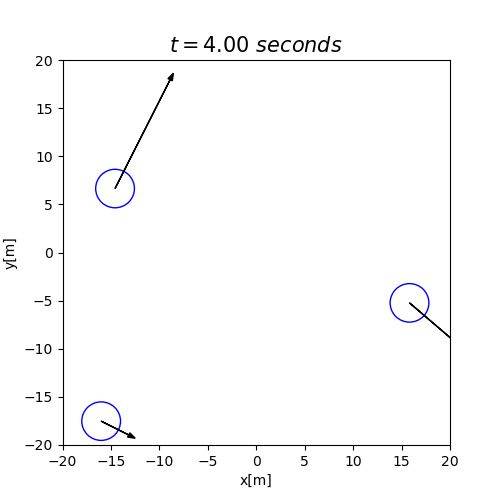

In [11]:
#Animaciones

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

#Función de inicio

def init():  
    
    ax.set_xlim(-limits[0],limits[0])
    ax.set_ylim(-limits[1],limits[1])
    
#Función de actualización

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15) 
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]     #Se agrega el vector velocidad reducido
        vy = p.GetRVelocityVector()[i,1]
        
        circle = plt.Circle((x,y), p.GetR(), color='b', fill = False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x, y, vx, vy, color='k', head_width=0.5)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)
#Animation.save('Billar.mp4')
plt.show()

In [12]:
"""      Profe no se pudo 

def calcula_potencial(p1, p2):           #Método que calcula la fuerza con la particula

        r1 = p1.GetPositionVector()
        r2 = p2.GetPositionVector()
        
        potencial = []
        
        for i in range(len(t)):
        
            f = 0
        
            if np.linalg.norm(r1[i] - r2[i]) < 4:

                # Al calcular la fuerza no se ponen los términos - R1 - R2 porque corresponderían a abolladuras de las esferas, 
                # sin embargo en el modelo, al establecerse que la distancia mínima a la que pueden estar es justamente la suma
                # de los radios, no va a haber compresión alguna
                f = 100* (np.linalg.norm(r1[i] - r2[i]))**3 * (r1[i] - r2[i]) / np.linalg.norm(r1[i] - r2[i])
                potencial.append(np.dot(f,r1[i]-r2[i]))
                
            else:
                
                potencial.append(0)
                
        return potencial
"""

'      Profe no se pudo \n\ndef calcula_potencial(p1, p2):           #Método que calcula la fuerza con la particula\n\n        r1 = p1.GetPositionVector()\n        r2 = p2.GetPositionVector()\n        \n        potencial = []\n        \n        for i in range(len(t)):\n        \n            f = 0\n        \n            if np.linalg.norm(r1[i] - r2[i]) < 4:\n\n                # Al calcular la fuerza no se ponen los términos - R1 - R2 porque corresponderían a abolladuras de las esferas, \n                # sin embargo en el modelo, al establecerse que la distancia mínima a la que pueden estar es justamente la suma\n                # de los radios, no va a haber compresión alguna\n                f = 100* (np.linalg.norm(r1[i] - r2[i]))**3 * (r1[i] - r2[i]) / np.linalg.norm(r1[i] - r2[i])\n                potencial.append(np.dot(f,r1[i]-r2[i]))\n                \n            else:\n                \n                potencial.append(0)\n                \n        return potencial\n'

<IPython.core.display.Javascript object>


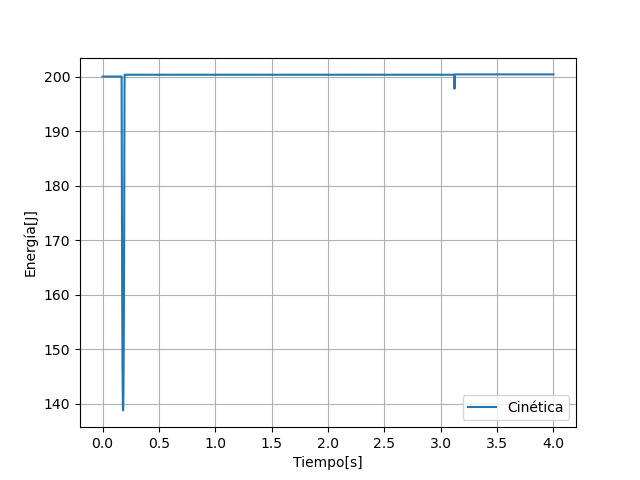

In [13]:
a = Particles[0].GetK()
b = Particles[1].GetK()
c = Particles[2].GetK()

#d = Particles[0].GetP()
#e = Particles[1].GetP()
#f = Particles[2].GetP()

K = a+b+c
#P = d#+e+f

#E = K + P

plt.figure()
plt.plot(t,K, label = 'Cinética')
plt.xlabel('Tiempo[s]')
plt.ylabel('Energía[J]')
plt.grid()
plt.legend()
#plt.scatter(t,P)
#plt.scatter(t,E)

# Tiempo libre medio

In [14]:
#Obtener los datos de internet

!rm Data/*
file = 'Data.dat'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('\n Descargado')
else:
    Path_ = file

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


<IPython.core.display.Javascript object>


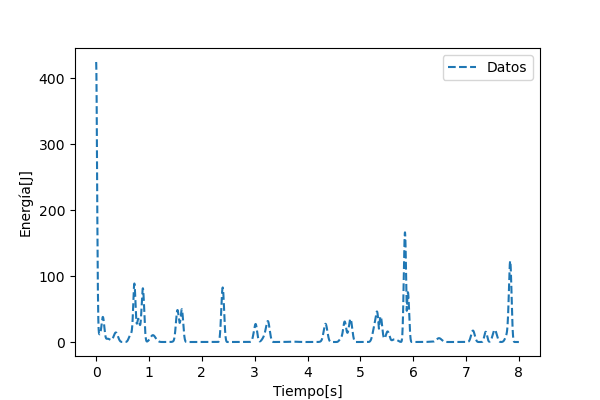

In [15]:
#Cargando datos necesarios

data = np.loadtxt(Path_)     
tiempo = data[:,0]
Energia = data[:,1]

plt.figure(figsize=(6,4))
plt.plot(tiempo, Energia, '--', label = 'Datos')
plt.xlabel('Tiempo[s]')
plt.ylabel('Energía[J]')
plt.legend()

In [16]:
#Quitar el valor medio de los datos para que esté centrado en cero

a = np.mean(Energia)

Energia = Energia - a

<IPython.core.display.Javascript object>


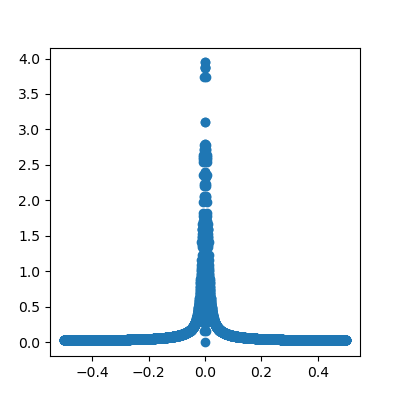

In [17]:
#Calculando

fft = np.fft.fft(Energia)                  #Transformada de Fourier cantidad de manchas
Freq = np.fft.fftfreq(len(Energia),1)      #Obtener frecuencias, len(Energia) se refiere al número de puntos, paso temporal
ffta = np.abs(fft/len(Energia))            #El paso temporal es de a 0.001s, es importante porque el periodo se obtendrá en x10^-3s

plt.figure(figsize=(4,4))
plt.scatter(Freq,ffta)

In [18]:
#Cómo es simétrico se puede descartar la información menor a cero

Paso_tem = tiempo[1]- tiempo[0]

mask = Freq < 0

ffta[mask] = 0

In [19]:
#Para encontrar el modo que más contribuye y el periodo

ii = np.argmax(np.abs(ffta))  #Oscilación fundamental

Periodo = 1/Freq[ii]
Periodo_s = 1/(Freq[ii]*1/Paso_tem)     #Se ajusta la temporalidad a seg

In [20]:
#Para depurar las frecuencias

for i in range(len(Freq)):
    
    if i != ii:
        
        fft[i] = 0                #Para dejar solamente el modo predominante, se ajusta la transformada 
                                  #de Fourier a cero para todas las demás frecuencia

<IPython.core.display.Javascript object>


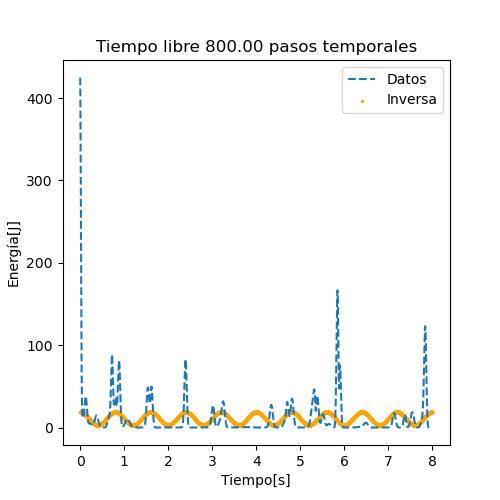

Text(0.5, 1.0, 'Tiempo libre 800.00 pasos temporales')

In [21]:
#Reproduciendo gráfica con transformada inversa

y = np.fft.ifft(2*fft) + a          #Se multiplica por 2 para ajustar normalización y se suma a para centrar en el mismo valor que los datos

plt.figure(figsize=(5,5))
plt.plot(tiempo,Energia+a, '--', label = 'Datos')
plt.scatter(tiempo,np.real(y), c='orange', label = 'Inversa', s=2)
plt.xlabel('Tiempo[s]')
plt.ylabel('Energía[J]')
plt.legend()
plt.title('Tiempo libre {:.2f} pasos temporales'.format(Periodo))

# Termodinámica

In [22]:
#Con odeint para comparar

def System(r,t):
    
    dT1dt = -c*(r[0]-r[1])
    dT2dt = c*(r[0]-r[1])
    
    return [dT1dt,dT2dt]

#Condiciones iniciales

c = 389.6*0.01/(0.3*3/2*8.314)
r0 = [400.,200.]

#Discretización

N = 400
t = np.linspace(0.,.3,N)

#Proceso de integración

r = integrate.odeint( System, r0, t )

In [23]:
# Solución teórica

def system(t): 
    
    T1 = 100*np.exp(-2*c*t) + 300
    T2 = -100*np.exp(-2*c*t) + 300
    
    return np.array([T1,T2])

In [24]:
q = system(t)

In [25]:
#Sistema de ecuaciones

def f0(T1,T2):
    
    return -c*(T1-T2)

def f1(T1,T2):
    
    return c*(T1-T2)

In [26]:
#Condicones iniciales

x0 = np.array([400.,200.])

In [27]:
#Euler de segundo orden

def GetEuler2(f0,f1,r,t): 
    
    h = (t[-1] - t[0])/(len(t)-1)
    
    T1 = np.zeros(len(t))
    T2 = np.zeros(len(t))
    
    T1[0] = x0[0]
    T2[0] = x0[1]
    
    K1 = np.zeros(2)
    K2 = np.zeros(2)    
          
    for i in range(1,len(t)):
        
        K1[0] = f0(T1[i-1],T2[i-1])
        K1[1] = f1(T1[i-1],T2[i-1])
        
        K2[0] = f0(T1[i-1] + h*K1[0], T2[i-1] + h*K1[1])
        K2[1] = f1(T1[i-1] + h*K1[0], T2[i-1] + h*K1[1])
                
        T1[i] = T1[i-1] + 0.5*h*(K1[0] + K2[0])
        T2[i] = T2[i-1] + 0.5*h*(K1[1] + K2[1])
        
    return T1, T2

In [28]:
f01,f11 = GetEuler2(f0,f1,x0,t)

<IPython.core.display.Javascript object>


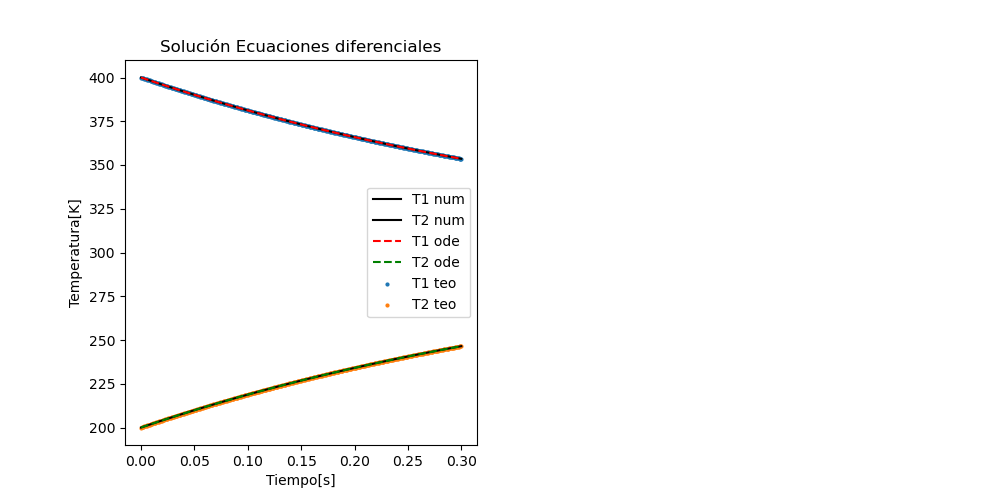

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.set_title('Solución Ecuaciones diferenciales')
ax.plot(t,f01, label = 'T1 num', c = 'k')
ax.plot(t, f11, label = 'T2 num', c = 'k')
ax.plot(t,r[:,0], '--', label='T1 ode', c='r')
ax.plot(t,r[:,1], '--',label='T2 ode', c='g')
ax.scatter(t,q[0,:],label='T1 teo', s = 4)
ax.scatter(t,q[1,:],label='T2 teo', s = 4)
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Temperatura[K]')
ax.legend()

Para encontrar la temperatura en el límite termodonámico, cuando t tiende a infinito, se expande el intervalo y se vuelve a calcular la solución numérica y la solución teórica.

In [30]:
#Nuevo intervalo

N = 800
t = np.linspace(0.,5,N)

ql = system(t)
rl = integrate.odeint( System, r0, t )
f0l,f1l = GetEuler2(f0,f1,x0,t)

<IPython.core.display.Javascript object>


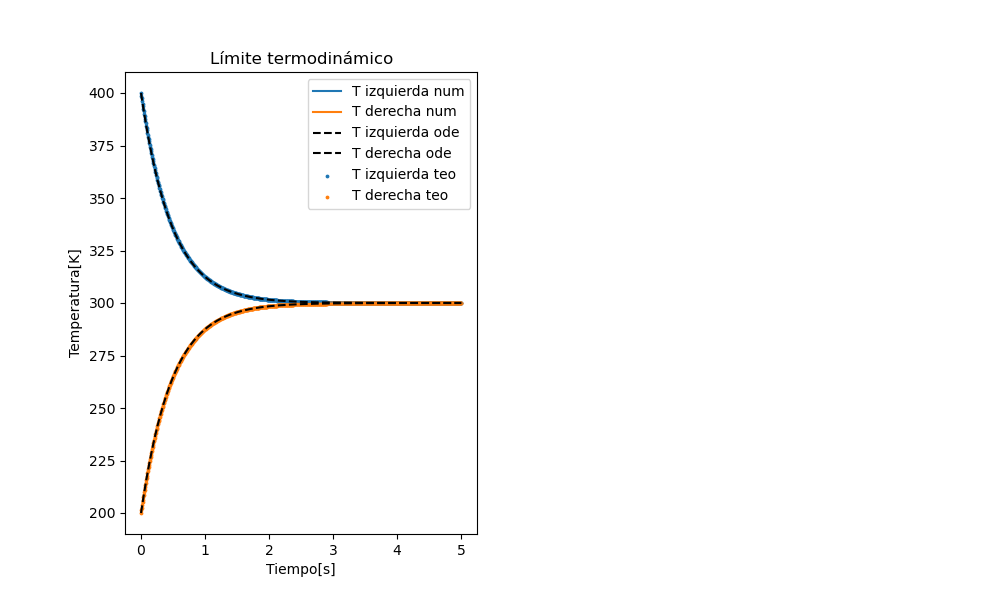

In [31]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)
ax.plot(t,f0l, label = 'T izquierda num')
ax.set_title('Límite termodinámico')
ax.plot(t, f1l, label = 'T derecha num')
ax.plot(t,rl[:,0], '--', label='T izquierda ode', c='k')
ax.plot(t,rl[:,1], '--',label='T derecha ode', c='k')
ax.scatter(t,ql[0,:],label='T izquierda teo', s = 3)
ax.scatter(t,ql[1,:],label='T derecha teo', s = 3)
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Temperatura[K]')
ax.legend()

En el límite termodinámico se alcanzaría el equilibrio para una temperatura de 300K. Que la temperatura se encuentre justo en medio, a pesar de que el piston se encuentra ligeramente desviado hacia la derecha responde a que hay otra forma de transferencia de energía además del movimiento del pistón: el cable.

# Cython

#### Correr primero programa de c++ para generar el archivo 'MisDatos.dat'

In [32]:
# Derivada analítica

def derivada(x): 
    
    return -2*x*np.exp(-x**2)

#Función

def f(x):
    
    return np.exp(-x**2)

In [33]:
#Derivada central

def dev_central(x):
    
    derivada = []
    
    for i in range(len(x)-1):
        
        if i == 0:        #derivada derecha
            
            a = ( f(x[i+1]) - f(x[i]) )/ dx
            
            derivada.append(a)
        
        if i != 0 and i < len(x)-1:     #derivada central
            
            a = ( f(x[i+1]) - f(x[i-1]) )/ (2*dx)
            
            derivada.append(a)
            
        else: 
            
            a = ( f(x[i]) - f(x[i-1]) )/ dx
            
            derivada.append(a)
                        
    return derivada

In [34]:
#Parámetros

dx = 0.01 #Paso de derivación

x = np.linspace(-20,20,int(40/dx))    #Valores de x

In [35]:
datos = pd.read_csv('MisDatos.dat', delimiter=' ')    #Se lee archivo generado con c++
datos.keys()

x1 = datos['X']
derivada_c = datos['D']

mask = derivada_c > 2
derivada_c[mask] = 0
mask1 = derivada_c < -2
derivada_c[mask1] = 0

<ipython-input-35-86ebb3f3caaf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derivada_c[mask] = 0
<ipython-input-35-86ebb3f3caaf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derivada_c[mask1] = 0


<IPython.core.display.Javascript object>


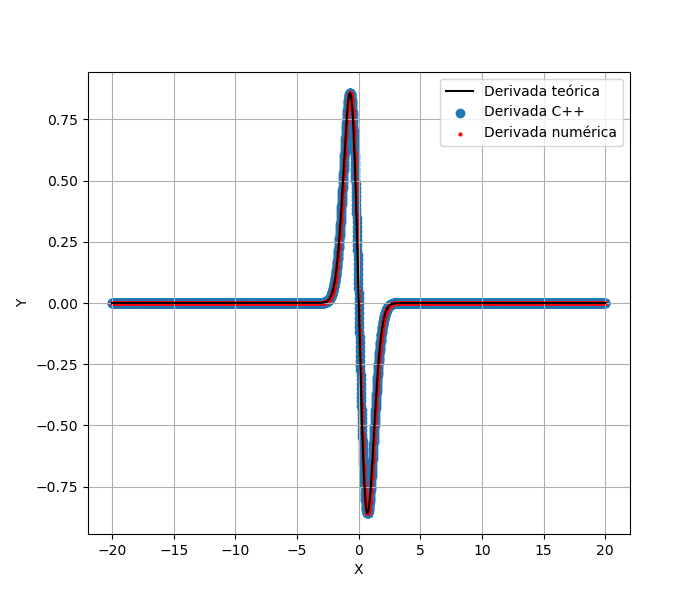

In [36]:
teo = derivada(x)
num = dev_central(x)

plt.figure(figsize=(7,6))
plt.plot(x,teo,'-',label = 'Derivada teórica', c='k')
plt.scatter(x1,derivada_c, label = 'Derivada C++')
plt.scatter(x,num, label = 'Derivada numérica', c='r', s=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()